In [1]:
import re
import networkx as nx
import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
import yaml
import matplotlib.colors as mcolors
import pandas as pd
import subprocess
import sys
build_dir = '/Users/letshopethisworks2/CLionProjects/SALBP_ILS/cmake-build-python_interface/'

sys.path.insert(0, build_dir)
sys.path.append('../src')
sys.path.append('../src/constraint_disc')
from metrics.node_and_edge_features import randomized_kahns_algorithm
from alb_instance_compressor import *
from constraint_disc.lstd import *
from constraint_disc.constraint_discovery import *
from constraint_disc.beam_search import remove_edges
from SALBP_solve import salbp1_bbr_call, parse_alb_results_new_bbr,salbp1_mhh_solve

from copy import deepcopy
import ILS_ALBP

In [2]:
test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")

In [3]:
test_problem

{'num_tasks': 20,
 'cycle_time': 1000,
 'task_times': {'1': 599,
  '2': 464,
  '3': 579,
  '4': 489,
  '5': 624,
  '6': 430,
  '7': 411,
  '8': 524,
  '9': 478,
  '10': 585,
  '11': 570,
  '12': 622,
  '13': 452,
  '14': 344,
  '15': 720,
  '16': 502,
  '17': 355,
  '18': 813,
  '19': 342,
  '20': 473},
 'precedence_relations': [['1', '5'],
  ['2', '7'],
  ['3', '8'],
  ['4', '6'],
  ['4', '9'],
  ['4', '10'],
  ['5', '11'],
  ['6', '12'],
  ['7', '13'],
  ['8', '13'],
  ['11', '15'],
  ['12', '14'],
  ['13', '16'],
  ['13', '17'],
  ['14', '18'],
  ['15', '19'],
  ['16', '20']]}

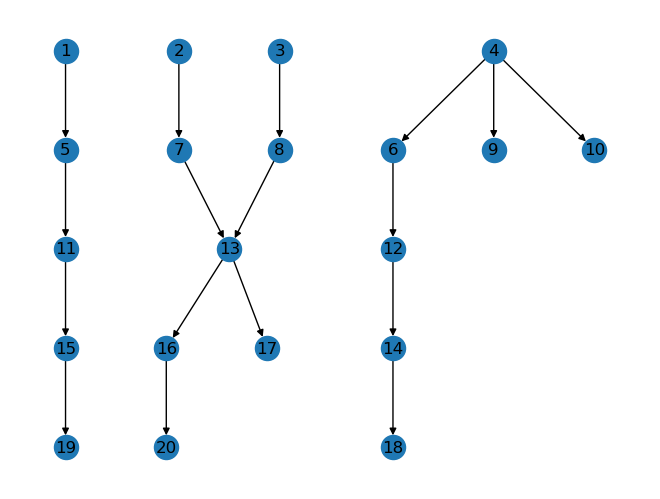

In [4]:
def plot_salbp_graph(G):
    # Compute layout
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

    # Extract edge probabilities (default to 0 if missing)
    edge_probs = [G[u][v].get('prob', 0) for u, v in G.edges()]
    
    # Normalize for color mapping
    vmin, vmax = min(edge_probs), max(edge_probs)

    # Create figure and axis explicitly
    fig, ax = plt.subplots(figsize=(8, 6))

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800, edgecolors='black', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', ax=ax)

    # Draw edges with colormap
    edges = nx.draw_networkx_edges(
        G,
        pos,
        edge_color=edge_probs,
        edge_cmap=plt.cm.viridis,
        edge_vmin=vmin,
        edge_vmax=vmax,
        width=2,
        ax=ax
    )

    # Add colorbar *using the same Axes*
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])  # required for colorbar
    fig.colorbar(sm, ax=ax, label="Edge Probability")

    # Final touches
    ax.set_title("SALBP Graph Colored by Edge Probability")
    ax.axis("off")
    plt.tight_layout()
    plt.show()
plot_salbp_dict(test_problem)

In [5]:
feasible_sequences = get_feasible_seq(test_problem, 2, 42)
print(feasible_sequences)

G_max_close = seqs_to_dag(feasible_sequences)






[['1', '2', '5', '4', '6', '7', '3', '12', '8', '14', '13', '9', '10', '11', '16', '17', '20', '15', '18', '19'], ['2', '7', '4', '6', '1', '5', '11', '10', '12', '9', '3', '14', '8', '13', '18', '15', '17', '19', '16', '20']]


In [6]:

edge_probs = edge_prob_generation(test_problem, G_max_close, seed=42)
nx.set_edge_attributes(G_max_close, edge_probs, name='prob')
G_max_red = nx.transitive_reduction(G_max_close)
nx.set_edge_attributes(G_max_red, edge_probs, name='prob')
nx.set_edge_attributes(G_max_close, 1, name = 't_cost' )
edge_probs

Seed is  42
edges to perturb,  [('12', '14'), ('1', '16'), ('2', '7'), ('2', '17'), ('2', '12'), ('12', '8'), ('11', '20'), ('8', '13'), ('11', '16'), ('5', '3'), ('1', '18'), ('1', '17'), ('11', '17'), ('2', '10'), ('2', '14'), ('7', '14'), ('9', '19'), ('15', '19'), ('5', '20'), ('2', '11'), ('6', '13'), ('2', '8'), ('1', '11'), ('13', '18'), ('8', '17'), ('14', '13'), ('9', '15'), ('10', '19'), ('12', '13'), ('6', '3')]


{('11', '15'): 0.1,
 ('14', '18'): 0.1,
 ('13', '16'): 0.1,
 ('15', '19'): 0.9,
 ('4', '10'): 0.1,
 ('2', '7'): 0.9,
 ('4', '9'): 0.1,
 ('1', '5'): 0.1,
 ('4', '6'): 0.1,
 ('6', '12'): 0.1,
 ('12', '14'): 0.9,
 ('7', '13'): 0.1,
 ('5', '11'): 0.1,
 ('3', '8'): 0.1,
 ('13', '17'): 0.1,
 ('16', '20'): 0.1,
 ('8', '13'): 0.9,
 ('1', '9'): 0.9,
 ('6', '19'): 0.9,
 ('7', '12'): 0.9,
 ('6', '17'): 0.9,
 ('18', '19'): 0.9,
 ('12', '15'): 0.9,
 ('4', '8'): 0.9,
 ('12', '17'): 0.9,
 ('2', '14'): 0.1,
 ('2', '13'): 0.9,
 ('6', '10'): 0.9,
 ('17', '19'): 0.9,
 ('1', '8'): 0.9,
 ('2', '9'): 0.9,
 ('5', '20'): 0.1,
 ('7', '16'): 0.9,
 ('14', '20'): 0.9,
 ('8', '20'): 0.9,
 ('5', '3'): 0.1,
 ('6', '20'): 0.9,
 ('3', '18'): 0.9,
 ('6', '3'): 0.1,
 ('3', '19'): 0.9,
 ('1', '12'): 0.9,
 ('2', '8'): 0.1,
 ('12', '20'): 0.9,
 ('4', '16'): 0.9,
 ('17', '20'): 0.9,
 ('12', '13'): 0.1,
 ('7', '18'): 0.9,
 ('7', '15'): 0.9,
 ('1', '16'): 0.1,
 ('7', '19'): 0.9,
 ('7', '17'): 0.9,
 ('2', '12'): 0.1,
 ('3', '2

In [7]:
set1 = set([('2', '5'), ('4', '6'), ('2', '19'), ('2', '10'), ('12', '15'), ('1', '12'), ('4', '18'), ('7', '9'), ('10', '18'), ('5', '20'), ('6', '12'), ('1', '5'), ('5', '3'), ('8', '17'), ('10', '15'), ('5', '14'), ('7', '18'), ('6', '19'), ('12', '9'), ('7', '14'), ('6', '9'), ('8', '15'), ('8', '13'), ('1', '17'), ('9', '18'), ('12', '20'), ('2', '18'), ('11', '20'), ('7', '12'), ('5', '15')])
set2 = set([('5', '13'), ('4', '9'), ('7', '15'), ('6', '14'), ('2', '15'), ('2', '13'), ('7', '16'), ('8', '17'), ('3', '19'), ('2', '6'), ('13', '16'), ('16', '20'), ('4', '11'), ('2', '14'), ('13', '20'), ('4', '20'), ('6', '16'), ('8', '18'), ('7', '17'), ('14', '19'), ('14', '13'), ('4', '12'), ('5', '11'), ('5', '15'), ('10', '17'), ('6', '13'), ('11', '16'), ('9', '20'), ('7', '9'), ('7', '20')])
set2

{('10', '17'),
 ('11', '16'),
 ('13', '16'),
 ('13', '20'),
 ('14', '13'),
 ('14', '19'),
 ('16', '20'),
 ('2', '13'),
 ('2', '14'),
 ('2', '15'),
 ('2', '6'),
 ('3', '19'),
 ('4', '11'),
 ('4', '12'),
 ('4', '20'),
 ('4', '9'),
 ('5', '11'),
 ('5', '13'),
 ('5', '15'),
 ('6', '13'),
 ('6', '14'),
 ('6', '16'),
 ('7', '15'),
 ('7', '16'),
 ('7', '17'),
 ('7', '20'),
 ('7', '9'),
 ('8', '17'),
 ('8', '18'),
 ('9', '20')}

[('5', '13'), ('4', '9'), ('7', '15'), ('6', '14'), ('2', '15'), ('2', '13'), ('7', '16'), ('8', '17'), ('3', '19'), ('2', '6'), ('13', '16'), ('16', '20'), ('4', '11'), ('2', '14'), ('13', '20'), ('4', '20'), ('6', '16'), ('8', '18'), ('7', '17'), ('14', '19'), ('14', '13'), ('4', '12'), ('5', '11'), ('5', '15'), ('10', '17'), ('6', '13'), ('11', '16'), ('9', '20'), ('7', '9'), ('7', '20')]

In [8]:
G_max_red.edges(data=True)

OutEdgeDataView([('1', '5', {'prob': 0.1}), ('2', '4', {'prob': 0.9}), ('2', '7', {'prob': 0.9}), ('2', '5', {'prob': 0.9}), ('5', '12', {'prob': 0.9}), ('5', '3', {'prob': 0.1}), ('5', '11', {'prob': 0.1}), ('5', '10', {'prob': 0.9}), ('4', '6', {'prob': 0.1}), ('6', '12', {'prob': 0.1}), ('6', '3', {'prob': 0.1}), ('6', '11', {'prob': 0.9}), ('6', '10', {'prob': 0.9}), ('7', '12', {'prob': 0.9}), ('7', '3', {'prob': 0.9}), ('7', '11', {'prob': 0.9}), ('7', '10', {'prob': 0.9}), ('3', '8', {'prob': 0.1}), ('3', '14', {'prob': 0.9}), ('12', '8', {'prob': 0.1}), ('12', '14', {'prob': 0.9}), ('12', '9', {'prob': 0.9}), ('8', '13', {'prob': 0.9}), ('14', '13', {'prob': 0.1}), ('13', '15', {'prob': 0.9}), ('13', '16', {'prob': 0.1}), ('13', '18', {'prob': 0.1}), ('13', '17', {'prob': 0.1}), ('9', '15', {'prob': 0.1}), ('9', '16', {'prob': 0.9}), ('9', '18', {'prob': 0.9}), ('9', '17', {'prob': 0.9}), ('10', '15', {'prob': 0.9}), ('10', '16', {'prob': 0.9}), ('10', '18', {'prob': 0.9}), ('1

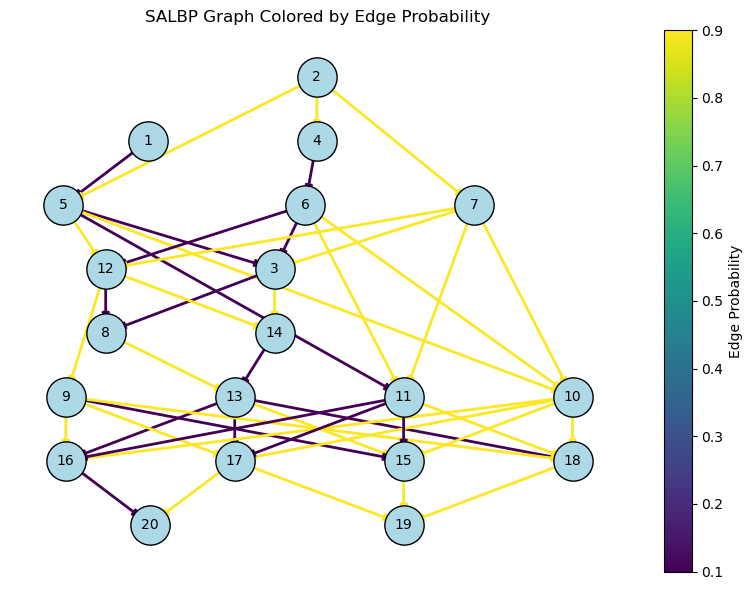

In [9]:
plot_salbp_graph(G_max_red)

In [10]:
test_problem

{'num_tasks': 20,
 'cycle_time': 1000,
 'task_times': {'1': 599,
  '2': 464,
  '3': 579,
  '4': 489,
  '5': 624,
  '6': 430,
  '7': 411,
  '8': 524,
  '9': 478,
  '10': 585,
  '11': 570,
  '12': 622,
  '13': 452,
  '14': 344,
  '15': 720,
  '16': 502,
  '17': 355,
  '18': 813,
  '19': 342,
  '20': 473},
 'precedence_relations': [['1', '5'],
  ['2', '7'],
  ['3', '8'],
  ['4', '6'],
  ['4', '9'],
  ['4', '10'],
  ['5', '11'],
  ['6', '12'],
  ['7', '13'],
  ['8', '13'],
  ['11', '15'],
  ['12', '14'],
  ['13', '16'],
  ['13', '17'],
  ['14', '18'],
  ['15', '19'],
  ['16', '20']]}

In [ ]:
test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")
mh = constant_weight
#mh = salbp1_hoff_solve
selector_method = "beam_mh"
ex_fp = "/Users/letshopethisworks2/Documents/phd_paper_material/BBR-for-SALBP1/SALB/SALB/salb"
beam_config= {'width':3, 'depth':3}
#beam_config= {'width':10, 'depth':3}
do_greedy_run(test_problem, 15, G_max_close, ex_fp, mh,selector_method, time_limit=1,seed=42,beam_config= beam_config)

In [11]:
G_max_close.edges(data=True)

OutEdgeDataView([('1', '3', {'prob': 0.9, 't_cost': 1}), ('1', '5', {'prob': 0.1, 't_cost': 1}), ('1', '8', {'prob': 0.9, 't_cost': 1}), ('1', '9', {'prob': 0.9, 't_cost': 1}), ('1', '10', {'prob': 0.9, 't_cost': 1}), ('1', '11', {'prob': 0.1, 't_cost': 1}), ('1', '12', {'prob': 0.9, 't_cost': 1}), ('1', '13', {'prob': 0.9, 't_cost': 1}), ('1', '14', {'prob': 0.9, 't_cost': 1}), ('1', '15', {'prob': 0.9, 't_cost': 1}), ('1', '16', {'prob': 0.1, 't_cost': 1}), ('1', '17', {'prob': 0.1, 't_cost': 1}), ('1', '18', {'prob': 0.1, 't_cost': 1}), ('1', '19', {'prob': 0.9, 't_cost': 1}), ('1', '20', {'prob': 0.9, 't_cost': 1}), ('2', '3', {'prob': 0.9, 't_cost': 1}), ('2', '4', {'prob': 0.9, 't_cost': 1}), ('2', '5', {'prob': 0.9, 't_cost': 1}), ('2', '6', {'prob': 0.9, 't_cost': 1}), ('2', '7', {'prob': 0.9, 't_cost': 1}), ('2', '8', {'prob': 0.1, 't_cost': 1}), ('2', '9', {'prob': 0.9, 't_cost': 1}), ('2', '10', {'prob': 0.1, 't_cost': 1}), ('2', '11', {'prob': 0.1, 't_cost': 1}), ('2', '12'

In [12]:
# test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")
# #mh = os_weight
# #mh = salbp1_hoff_solve
# mh=constant_weight
# selector_method = "beam_mh"
# ex_fp = "/Users/letshopethisworks2/Documents/phd_paper_material/BBR-for-SALBP1/SALB/SALB/salb"
# beam_config= {'width':3, 'depth':3}
# #beam_config= {'width':1, 'depth':1}
# do_greedy_run(test_problem, 5, G_max_close, ex_fp, mh,selector_method, time_limit=1,seed=42,beam_config= beam_config,)

In [13]:
test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")
mh = constant_weight
#mh = salbp1_hoff_solve
selector_method = "random"
ex_fp = "/Users/letshopethisworks2/Documents/phd_paper_material/BBR-for-SALBP1/SALB/SALB/salb"
beam_config= {'width':3, 'depth':3}
#beam_config= {'width':10, 'depth':3}
do_greedy_run(test_problem, 15, G_max_close, ex_fp, mh,selector_method, time_limit=1,seed=42,beam_config= beam_config)

{'time': 3.9650561809539795,
 'OS': [0.8,
  0.8,
  0.7947368421052632,
  0.7947368421052632,
  0.7947368421052632,
  0.7894736842105263,
  0.7894736842105263,
  0.7842105263157895,
  0.7789473684210526,
  0.7789473684210526,
  0.7789473684210526,
  0.7736842105263158,
  0.7736842105263158,
  0.7684210526315789,
  0.7631578947368421,
  0.7578947368421053],
 'query_values': [14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13],
 'q_time': [0.36978697776794434,
  0.2611229419708252,
  0.24686121940612793,
  0.24863982200622559,
  0.2540879249572754,
  0.25455307960510254,
  0.2576441764831543,
  0.2453908920288086,
  0.22622394561767578,
  0.22504591941833496,
  0.23034286499023438,
  0.24135684967041016,
  0.2298572063446045,
  0.22152400016784668,
  0.2265169620513916,
  0.22584128379821777],
 'bin_lb': 12,
 'edges': [(),
  ('16', '20', 0.1, 1),
  ('5', '10', 0.9, 1),
  ('1', '5', 0.1, 1),
  ('15', '19', 0.9, 1),
  ('13', '18', 0.1, 1),
  ('13', 

In [14]:
test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")
mh = constant_weight
#mh = salbp1_hoff_solve
selector_method = "beam_mh"
ex_fp = "/Users/letshopethisworks2/Documents/phd_paper_material/BBR-for-SALBP1/SALB/SALB/salb"
beam_config= {'width':3, 'depth':3}
#beam_config= {'width':10, 'depth':3}
do_greedy_run(test_problem, 15, G_max_close, ex_fp, mh,selector_method, time_limit=1,seed=42,beam_config= beam_config)

{'time': 5.672438859939575,
 'OS': [0.8,
  0.8,
  0.7947368421052632,
  0.7894736842105263,
  0.7842105263157895,
  0.7789473684210526,
  0.7736842105263158,
  0.7684210526315789,
  0.7631578947368421,
  0.7578947368421053,
  0.7526315789473684,
  0.7473684210526316,
  0.7421052631578947,
  0.7368421052631579,
  0.7315789473684211,
  0.7263157894736842],
 'query_values': [14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  13,
  13,
  13,
  13,
  13],
 'q_time': [0.24546098709106445,
  0.4467320442199707,
  0.367722749710083,
  0.39421796798706055,
  0.36658620834350586,
  0.36226797103881836,
  0.35913968086242676,
  0.351377010345459,
  0.356503963470459,
  0.3480570316314697,
  0.34868764877319336,
  0.34149694442749023,
  0.3419027328491211,
  0.35468482971191406,
  0.3445148468017578,
  0.342724084854126],
 'bin_lb': 12,
 'edges': [(),
  ('2', '7'),
  ('2', '5'),
  ('5', '12'),
  ('1', '12'),
  ('5', '9'),
  ('1', '9'),
  ('5', '10'),
  ('1', '10'),
  ('6', '11'),
  

In [ ]:
test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")
#mh = os_weight
mh = salbp1_prioirity_solve
#mh = salbp1_hoff_solve
selector_method = "beam_ml"
ex_fp = "/Users/letshopethisworks2/Documents/phd_paper_material/BBR-for-SALBP1/SALB/SALB/salb"
#beam_config= {'width':3, 'depth':3}
beam_config= {'width':10, 'depth':3}
xp_config_fp = 
xp_config, ml_config, ml_model = load_and_backup_configs(xp_config_fp, backup_folder=save_folder)

do_greedy_run(test_problem, 20, G_max_close, ex_fp, mh,selector_method, time_limit=1,seed=42,beam_config= beam_config, ml_model = ml_model, ml_config=ml_config)

In [16]:
G_min = nx.DiGraph()
G_min.add_nodes_from(test_problem["task_times"].keys())
mh = salbp1_hoff_solve
G_max_red = nx.transitive_reduction(G_max_close)
G_max_red.add_edges_from((u, v, G_max_close.edges[u, v]) for u, v in G_max_red.edges)
edges = get_possible_edges(G_max_red, G_min)
calc_phi_mh(test_problem, G_max_close,edges, mh,10, old_value = 14, mode='lstd_mh')

array([ 1.9       ,  6.00832755, 19.        ,  3.16227766, 10.        ])

In [17]:
test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")
#mh = os_weight
#mh = salbp1_prioirity_solve
mh = salbp1_mhh_solve
selector_method = "lstd_prob"
ex_fp = "/Users/letshopethisworks2/Documents/phd_paper_material/BBR-for-SALBP1/SALB/SALB/salb"
#beam_config= {'width':3, 'depth':3}
beam_config= {'width':10, 'depth':3}
do_greedy_run(test_problem, 10, G_max_close, ex_fp, mh,selector_method, time_limit=1,seed=42,beam_config= beam_config)

Here is the prev val 14
Best edge ('18', '19', 0.9, 1) best_weight 1 best prob 0.9
phi_0 [ 26.9         85.06526906 269.           3.16227766  10.        ], phi_1 [ 26.  78. 234.   3.   9.] 
Here is the step [ 2.2        10.96526906 46.7         0.31227766  1.45      ]
Here is the prev val 0
Best edge ('15', '19', 0.9, 1) best_weight 1 best prob 0.9
phi_0 [ 26.  78. 234.   3.   9.], phi_1 [ 25.1         70.99352083 200.8          2.82842712   8.        ] 
Here is the step [ 2.155      10.55615521 43.24        0.31299423  1.4       ]
Here is the prev val 0
Best edge ('17', '20', 0.9, 1) best_weight 1 best prob 0.9
phi_0 [ 25.1         70.99352083 200.8          2.82842712   8.        ], phi_1 [ 24.2         64.02718173 169.4          2.64575131   7.        ] 
Here is the step [ 2.11       10.16769819 39.87        0.31496338  1.35      ]
Here is the prev val 0
Best edge ('17', '19', 0.9, 1) best_weight 1 best prob 0.9
phi_0 [ 24.2         64.02718173 169.4          2.64575131   7.       

{'time': 19.129615783691406,
 'OS': [0.8,
  0.8,
  0.8,
  0.7947368421052632,
  0.7894736842105263,
  0.7842105263157895,
  0.7789473684210526,
  0.7789473684210526,
  0.7736842105263158,
  0.7736842105263158,
  0.7736842105263158],
 'query_values': [14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13],
 'q_time': [16.30393099784851,
  0.30648088455200195,
  0.29232192039489746,
  0.2704489231109619,
  0.28580188751220703,
  0.27589917182922363,
  0.2666361331939697,
  0.2686190605163574,
  0.32315492630004883,
  0.2693212032318115,
  0.26668810844421387],
 'bin_lb': 12,
 'edges': [(),
  ('3', '8', 0.1, 1),
  ('16', '20', 0.1, 1),
  ('11', '17', 0.1, 1),
  ('11', '16', 0.1, 1),
  ('18', '19', 0.9, 1),
  ('11', '20', 0.1, 1),
  ('11', '15', 0.1, 1),
  ('9', '15', 0.1, 1),
  ('13', '17', 0.1, 1),
  ('15', '19', 0.9, 1)]}

In [18]:
test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")
#mh = os_weight
#mh = salbp1_prioirity_solve
mh = salbp1_mhh_solve
selector_method = "lstd_mh"
ex_fp = "/Users/letshopethisworks2/Documents/phd_paper_material/BBR-for-SALBP1/SALB/SALB/salb"
#beam_config= {'width':3, 'depth':3}
beam_config= {'width':10, 'depth':3}
do_greedy_run(test_problem, 10, G_max_close, ex_fp, mh,selector_method, time_limit=1,seed=42,beam_config= beam_config)

Here is the prev val 14
Best edge ('9', '17', 0.9, 1) best_weight 1 best prob 0.9
phi_0 [ 1.          3.16227766 10.          3.16227766 10.        ], phi_1 [0. 0. 0. 3. 9.] 
Here is the step [ 1.          3.16227766 10.          0.31227766  1.45      ]
Here is the prev val 13


KeyboardInterrupt: 

node_labels {'1': '1', '2': '2', '5': '3', '4': '4', '7': '5', '6': '6', '3': '7', '10': '8', '12': '9', '11': '10', '9': '11', '8': '12', '14': '13', '13': '14', '16': '15', '15': '16', '17': '17', '18': '18', '20': '19', '19': '20'}


G_max_red edges [('1', '5'), ('2', '5'), ('2', '7'), ('2', '4'), ('5', '3'), ('5', '10'), ('5', '11'), ('5', '12'), ('4', '6'), ('6', '3'), ('6', '10'), ('6', '11'), ('6', '12'), ('7', '3'), ('7', '10'), ('7', '11'), ('7', '12'), ('3', '14'), ('3', '8'), ('12', '14'), ('12', '9'), ('12', '8'), ('8', '13'), ('14', '13'), ('13', '16'), ('13', '18'), ('13', '17'), ('13', '15'), ('9', '16'), ('9', '18'), ('9', '17'), ('9', '15'), ('10', '16'), ('10', '18'), ('10', '17'), ('10', '15'), ('11', '16'), ('11', '18'), ('11', '17'), ('11', '15'), ('16', '20'), ('17', '19'), ('17', '20'), ('15', '19'), ('18', '19')]



In [19]:
test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")
#mh = os_weight
#mh = salbp1_prioirity_solve
mh = salbp1_mhh_solve
selector_method = "beam_mh"
ex_fp = "/Users/letshopethisworks2/Documents/phd_paper_material/BBR-for-SALBP1/SALB/SALB/salb"
beam_config= {'width':3, 'depth':3}
#beam_config= {'width':10, 'depth':3}
do_greedy_run(test_problem, 10, G_max_close, ex_fp, mh,selector_method, time_limit=1,seed=42,beam_config= beam_config)

{'time': 7.125375986099243,
 'OS': [0.8,
  0.7947368421052632,
  0.7947368421052632,
  0.7894736842105263,
  0.7842105263157895,
  0.7789473684210526,
  0.7736842105263158,
  0.7684210526315789,
  0.7631578947368421,
  0.7578947368421053,
  0.7526315789473684],
 'query_values': [14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
 'q_time': [0.31212687492370605,
  0.7440907955169678,
  0.7082240581512451,
  0.6928441524505615,
  0.6803009510040283,
  0.6811079978942871,
  0.6894299983978271,
  0.6658120155334473,
  0.6512441635131836,
  0.6545407772064209,
  0.6453738212585449],
 'bin_lb': 12,
 'edges': [(),
  ('9', '17'),
  ('2', '7'),
  ('2', '5'),
  ('5', '12'),
  ('1', '12'),
  ('5', '9'),
  ('1', '9'),
  ('5', '10'),
  ('1', '10'),
  ('6', '11')]}

In [21]:
test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")
#mh = os_weight
#mh = salbp1_prioirity_solve
mh = salbp1_prioirity_solve
selector_method = "beam_mh"
ex_fp = "/Users/letshopethisworks2/Documents/phd_paper_material/BBR-for-SALBP1/SALB/SALB/salb"
beam_config= {'width':3, 'depth':3}
#beam_config= {'width':10, 'depth':3}
do_greedy_run(test_problem, 10, G_max_close, ex_fp, mh,selector_method, time_limit=1,seed=42,beam_config= beam_config)

using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using seed 42
using 

{'time': 18.243576049804688,
 'OS': [0.8,
  0.7947368421052632,
  0.7947368421052632,
  0.7894736842105263,
  0.7842105263157895,
  0.7789473684210526,
  0.7736842105263158,
  0.7684210526315789,
  0.7631578947368421,
  0.7578947368421053],
 'query_values': [14, 13, 13, 13, 13, 13, 13, 13, 13, 12],
 'q_time': [0.315216064453125,
  1.4801428318023682,
  1.4328551292419434,
  1.5014121532440186,
  1.5680010318756104,
  2.3302550315856934,
  2.5515549182891846,
  2.4293339252471924,
  2.242138147354126,
  2.391494035720825],
 'bin_lb': 12,
 'edges': [(),
  ('7', '11'),
  ('2', '7'),
  ('2', '5'),
  ('5', '12'),
  ('1', '12'),
  ('5', '9'),
  ('1', '9'),
  ('6', '11'),
  ('10', '16')]}

original edges:  [('1', '5'), ('2', '7'), ('2', '4'), ('2', '5'), ('5', '11'), ('5', '10'), ('5', '3'), ('5', '12'), ('4', '6'), ('6', '11'), ('6', '10'), ('6', '3'), ('6', '12'), ('7', '11'), ('7', '10'), ('7', '3'), ('7', '12'), ('3', '8'), ('3', '14'), ('12', '8'), ('12', '9'), ('12', '14'), ('8', '13'), ('14', '13'), ('13', '16'), ('13', '17'), ('13', '15'), ('13', '18'), ('9', '16'), ('9', '17'), ('9', '15'), ('9', '18'), ('10', '16'), ('10', '17'), ('10', '15'), ('10', '18'), ('11', '16'), ('11', '17'), ('11', '15'), ('11', '18'), ('16', '20'), ('17', '20'), ('17', '19'), ('15', '19'), ('18', '19')]


In [ ]:
import networkx as nx


In [ ]:
#test_to_remove = [('10', '16'), ('17', '19'), ('2', '5'), ('7', '11')]
test_to_remove = [('6','3')
]
# test_to_remove = [('2', '4'),
#   ('2', '6'),
#   ('5', '3'),
#   ('5', '12'),
#   ('5', '8'),
#   ('5', '10'),
#   ('1', '10'),
#   ('5', '9'),
#   ('1', '12'),
#   ('1', '9'),
#   ('5', '14'),
#   ('5', '13'),
#   ('7', '3'),
#   ('2', '3'),
#   ('7', '12'),
#   ('7', '9'),
#   ('7', '14'),
#   ('3', '8'),
#   ('3', '14'),
# ]
test_gmax_close = G_max_close.copy()
print("before", test_gmax_close)
test_gmax_close.remove_edges_from(test_to_remove)
print("after", test_gmax_close)

G_max_red = nx.transitive_reduction(test_gmax_close)
test_salbp, new_to_old = set_new_edges(G_max_red, test_problem)
orig_bbr = False
if "BBR-for-SALBP1/" in ex_fp:
    orig_bbr = True
res = salbp1_bbr_call(test_salbp,ex_fp, 1, w_bin_pack=True, time_limit=2, orig_bbr=orig_bbr)
print('n_stations', res['n_stations'])
task_station = {}
for i, station in enumerate(res['task_assignments']):
    task_station[new_to_old[str(i+1)]] = station
sorted_dict = dict(sorted(task_station.items(), key=(lambda x: int(x[0]))))
true_assignments = [val for _,  val in sorted_dict.items()]
true_assignments
def check_feasibility_C(orig_problem, assignments, cycle_time=1000):
    station_loads = [0] * max(assignments)
    for task, station in enumerate(assignments):
        
        station_loads[station-1] += orig_problem['task_times'][str(task+1)]
    print("here are the station loads: ", station_loads)
    if max(station_loads)>cycle_time:
        idx, max_val = max(enumerate(station_loads), key=lambda x: x[1])
        print("Issue! ", idx, max_val)
check_feasibility_C(test_problem, true_assignments)


before DiGraph with 20 nodes and 152 edges
after DiGraph with 20 nodes and 151 edges
n_stations 13
here are the station loads:  [599, 953, 624, 990, 1000, 585, 622, 822, 976, 720, 813, 697, 975]


In [ ]:
import numpy as np

# def calc_phi_mh(orig_salbp, G_max_close, G_min,mh,remaining_budget, old_value = 0, mode='lstd_prob', **mhkwargs):
#     G_max_red = nx.transitive_closure(G_max_close)
#     edges = get_possible_edges(G_max_red, G_min)
#     att = 0
#     for i, edge in enumerate(edges):
#                 #This is to avoid repeat computations (i.e. e1->e2, e2->e1)
#         new_removed = [(edge[0], edge[1])]
#         # Store the current removal sequence
#         # Create list without current item
#         if len(edge) ==3:
#             edge_prob = edge[2]
#             edge_cost = 1
#         elif len(edge) ==4:
#             edge_prob = edge[2]
#             edge_cost = edge[3]
#         else:
#             edge_prob = 1
#             edge_cost = 1
#         if mode =="lstd_prob":
#             reward = 1 * edge_prob/edge_cost
            
#         elif mode == "lstd_mh":
#             G_max_red = remove_edges(G_max_close, new_removed)

#             new_salbp, new_to_old = set_new_edges(G_max_red, orig_salbp)
#             res = mh(new_salbp, **mhkwargs)
#             reward =  max( 0, edge_prob*(old_value - res['n_stations']))/edge_cost
#         att += reward
#     future_budget = max(0,remaining_budget- edge_cost)
#     phi = np.zeros(5)
#     phi[0] = att
#     phi[1] = att * np.sqrt(future_budget)
#     phi[2] = att * future_budget
#     phi[3] = np.sqrt(future_budget)
#     phi[4] = future_budget
#     return phi
   


# def train_lstd(orig_salbp, G_max_close_orig,G_min_orig, max_budget, mh, mode='lstd_prob', m=50, seed = 42, discount_factor=0.95, **mhkwargs):
#     theta = np.zeros(5)
#     A = np.zeros((5,5))
#     b = np.zeros(5)
#     rng = random.Random(seed)

#     print("THIS IS G_MIN", G_min_orig)
#     for _ in range(m):
#         G_min = G_min_orig.copy()
#         remaining_budget = max_budget
#         G_max_close = G_max_close_orig.copy()
#         G_max_red = nx.transitive_reduction(G_max_close)
#         G_max_red.add_edges_from((u, v, G_max_close.edges[u, v]) for u, v in G_max_red.edges)
#         edges = get_possible_edges(G_max_red, G_min)
#         phi_0 = calc_phi_mh(orig_salbp, G_max_close, G_min,mh,remaining_budget, old_value = 0, mode=mode, **mhkwargs)
#         while edges and remaining_budget > 0:
#             #initilization
#             best_edge = []
#             best_reward = 0
#             best_weight = 0
#             best_prob = 0
#             best_time = 1
#             #Getting best (i,j)
#             for edge in edges:
#                     new_removed = [(edge[0], edge[1])]
#                     G_max_close_test = G_max_close.copy()
#                     G_max_close_test.remove_edges_from(new_removed)
#                     if mode == 'lstd_mh':
#                         G_max_red = nx.transitive_closure(G_max_close_test)
#                         new_salbp, new_to_old = set_new_edges(G_max_red, orig_salbp)
#                         res = mh(new_salbp, **mhkwargs)
#                         weight = res['n_stations']
#                     else:
#                         weight = 1
                    
#                     phi = calc_phi_mh(orig_salbp, G_max_close_test, G_min,mh,remaining_budget, old_value = 0, mode=mode, **mhkwargs)
#                     reward = edge[2] * ( weight + np.dot(phi, theta) ) + (1-edge[2]) * np.dot(phi_0, theta)
#                     if reward >= best_reward:
#                         best_edge = edge
#                         best_prob = edge[2]
#                         best_weight = weight
#                         best_reward = reward
#                         if len(edge )==4:
#                             best_time = edge[3]
#             #update b
#             b= b + phi_0 * best_prob *best_weight
#             #State update
#             #random state transition
#             G_max_close, G_max_red, G_min, _= uncertain_query_prec_set(G_max_close, G_max_red, G_min, best_edge, rng)
#             #update budget
#             remaining_budget -= best_time
#             #update available edges
#             edges = get_possible_edges(G_max_red, G_min)
#             #update A and phi_0
#             phi_1 = calc_phi_mh(orig_salbp, G_max_close, G_min,mh,remaining_budget, old_value = 0, mode=mode, **mhkwargs)
#             step = phi_1 - discount_factor * phi_0
#             A = A + np.outer(phi_0, step)
#             phi_0 = phi_1
#         #update theta
#         theta = np.linalg.inv(A) @ b
#     return theta

G_min = nx.DiGraph()
G_min.add_nodes_from(G_max_close.nodes(data=True))  # preserve node attributes
G_min
theta = train_lstd(test_problem, G_max_close, G_min, 10, mh=constant_weight)


Here is the prev val 0
Best edge ('18', '19', 0.9) best_weight 1 best prob 0.9
phi_0 [ 26.9  80.7 242.1   3.    9. ], phi_1 [ 26.          73.53910524 208.           2.82842712   8.        ] 
Here is the step [ 2.2        10.83785002 44.5         0.31299423  1.4       ]
Here is the prev val 0
Best edge ('15', '19', 0.9) best_weight 1 best prob 0.9
phi_0 [ 26.          73.53910524 208.           2.82842712   8.        ], phi_1 [ 25.1         66.40835791 175.7          2.64575131   7.        ] 
Here is the step [ 2.155      10.45116523 41.085       0.31496338  1.35      ]
Here is the prev val 0
Best edge ('17', '19', 0.9) best_weight 1 best prob 0.9
phi_0 [ 25.1         66.40835791 175.7          2.64575131   7.        ], phi_1 [ 26.2         64.17663126 157.2          2.44948974   6.        ] 
Here is the step [ 0.21        5.44055821 26.36        0.31873606  1.3       ]
Here is the prev val 0
Best edge ('17', '20', 0.9) best_weight 1 best prob 0.9
phi_0 [ 26.2         64.17663126 157.2